## Imports and Functions

We begin by loading the necessary packages/modules.

In [65]:
import os
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

## Initialization

We define the file paths and load them onto separate dataframes.

In [66]:
gamma_estimates_csv = os.path.join('..', 'models', 'liq_param', 'liq_summary.csv')
adtv_csv = os.path.join('..', 'data', 'processed', 'summary_data.csv')

# load the relevant columns
gamma_df = pd.read_csv(gamma_estimates_csv, usecols=['Ticker', 'Mean Gamma Estimate'])
adtv_df = pd.read_csv(adtv_csv, usecols=['Ticker', 'ADTV'])

## Running the Regression

We perform a linear regression to calculate the intercept and slope estimates to derive the liquidity parameter from ADTV values.

In [67]:
# calc logs
gamma_df['log_gamma'] = np.log10(gamma_df['Mean Gamma Estimate'])
adtv_df['log_adtv'] = np.log10(adtv_df['ADTV'])

# merge on ticker
merged_df = pd.merge(gamma_df, adtv_df, on='Ticker')

# fit model
result = ols(formula="log_gamma ~ log_adtv", data=merged_df).fit()

# print results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              log_gamma   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     55.26
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           4.95e-06
Time:                        08:36:25   Log-Likelihood:                -21.353
No. Observations:                  15   AIC:                             46.71
Df Residuals:                      13   BIC:                             48.12
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5429      1.034     -0.525      0.6

c:\Users\Diana\miniforge3\envs\riskmanagement\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [68]:
# extract estimates
a_hat = result.params['Intercept']
b_hat = result.params['log_adtv']

print(f'Estimated intercept a: {a_hat}')
print(f'Estimated slope b: {b_hat}')

Estimated intercept a: -0.542866512474915
Estimated slope b: -1.494956715216012


## Displaying Regression Results

We display the regression results in a plot.

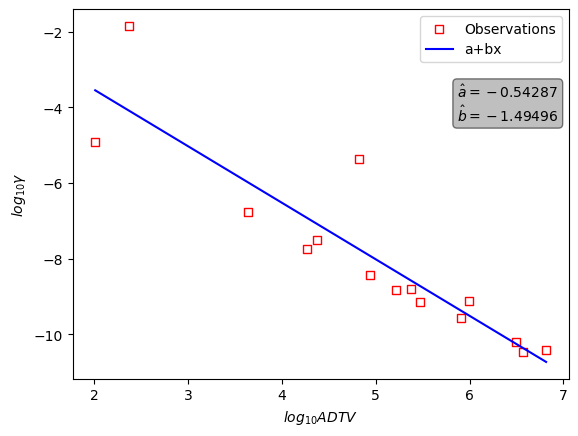

In [69]:
# plot observations
plt.scatter(merged_df['log_adtv'], merged_df['log_gamma'], label='Observations', marker='s', color='w', edgecolors='r')

# generate ADTV values to predict on
adtv_range = np.linspace(merged_df['log_adtv'].min(), merged_df['log_adtv'].max(), 100)

# predict gamma
predicted_gamma = a_hat + b_hat * adtv_range

# plot
plt.plot(adtv_range, predicted_gamma, label='a+bx', color='blue')
plt.xlabel('$log_{10}ADTV$')
plt.ylabel('$log_{10}\\gamma$')

plt.legend()

ax = plt.gca()
textstr = f'$\\hat{{a}} = {a_hat:.5f}$\n$\\hat{{b}} = {b_hat:.5f}$'
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)

ax.text(0.775, 0.8, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.savefig(os.path.join('..', 'reports', 'figures', 'adtv_reg.svg'), bbox_inches='tight')
plt.show()

## Finding Influential Observations 

We analyze the influence of each observaton in the model with the following:

- Leverage: How far an observation's independent variable values are from those of other observations. Observations with high leverage have a larger impact on the determination of the regression line.

- Studentized Residuals: Residuals adjusted for their standard deviation. Observations with large absolute studentized residuals are potential outliers.

- Cook's Distance: Influence of each observation on the fitted values. A large Cook's distance indicates that the observation has a large influence on the regression coefficients.

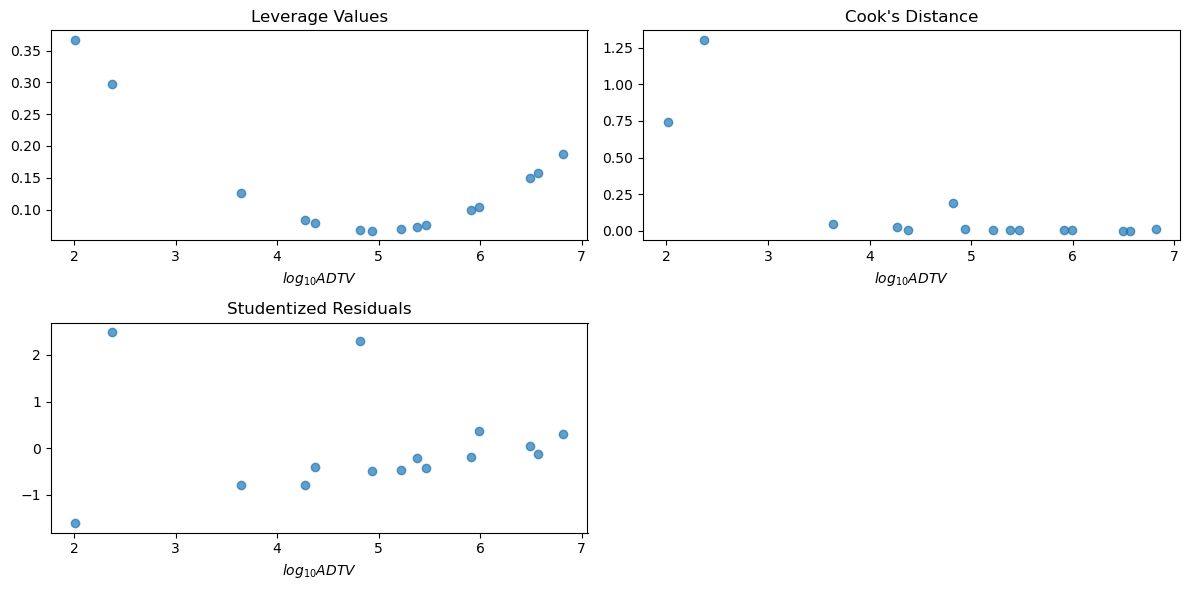

Rows with high leverage:


,Ticker,Mean Gamma Estimate,log_gamma,ADTV,log_adtv,Leverage,Cooks_dist,Studentized_resids
5,LISN,0.000012,-4.927088,102.627119,2.011262,0.366998,0.746185,-1.604387
14,VLRT,0.014213,-1.847317,236.659091,2.374123,0.297452,1.303865,2.481767


Rows with high studentized residuals:


,Ticker,Mean Gamma Estimate,log_gamma,ADTV,log_adtv,Leverage,Cooks_dist,Studentized_resids
4,KUD,0.000004,-5.359471,66002.847458,4.819563,0.067275,0.189409,2.291740
14,VLRT,0.014213,-1.847317,236.659091,2.374123,0.297452,1.303865,2.481767


Rows with high Cook's distance:


,Ticker,Mean Gamma Estimate,log_gamma,ADTV,log_adtv,Leverage,Cooks_dist,Studentized_resids
5,LISN,0.000012,-4.927088,102.627119,2.011262,0.366998,0.746185,-1.604387
14,VLRT,0.014213,-1.847317,236.659091,2.374123,0.297452,1.303865,2.481767


In [70]:
influence = result.get_influence()

# leverage (hat values)
merged_df['Leverage'] = influence.hat_matrix_diag

# Cook's distance
merged_df['Cooks_dist'] = influence.cooks_distance[0]

# studentized residuals
merged_df['Studentized_resids'] = influence.resid_studentized_internal

# plot
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.scatter(merged_df['log_adtv'], merged_df['Leverage'], alpha=0.7)
plt.title('Leverage Values')
plt.xlabel('$log_{10}ADTV$')

plt.subplot(2, 2, 2)
plt.scatter(merged_df['log_adtv'], merged_df['Cooks_dist'], alpha=0.7)
plt.title("Cook's Distance")
plt.xlabel('$log_{10}ADTV$')

plt.subplot(2, 2, 3)
plt.scatter(merged_df['log_adtv'], merged_df['Studentized_resids'], alpha=0.7)
plt.title('Studentized Residuals')
plt.xlabel('$log_{10}ADTV$')

plt.tight_layout()
plt.show()

# high leverage threshold
leverage_lim = 2 * (len(result.params)) / len(merged_df)
resid_lim = 2
cooks_lim = 4 / (len(merged_df) - len(result.params) - 1)

# find rows
high_leverage_indices = np.where(merged_df['Leverage'] > leverage_lim)[0]
high_resid_indices = np.where(np.abs(merged_df['Studentized_resids']) > resid_lim)[0]
high_cooks_indices = np.where(merged_df['Cooks_dist'] > cooks_lim)[0]

# print rows
print("Rows with high leverage:")
display(merged_df.iloc[high_leverage_indices])
print("Rows with high studentized residuals:")
display(merged_df.iloc[high_resid_indices])
print("Rows with high Cook's distance:")
display(merged_df.iloc[high_cooks_indices])

## Refitting the Model

We refit the model dropping KUD, LISN, and VLRT following our results from above and display estimates.

In [71]:
def calculate_ols_for_scenarios(dataframe, indices_to_drop):
    for indices in indices_to_drop:
        new_df = dataframe.drop(indices)
        result = ols(formula="log_gamma ~ log_adtv", data=new_df).fit()
        print(f"Model Summary dropping indices: {indices}")
        # extract estimates
        a_hat = result.params['Intercept']
        b_hat = result.params['log_adtv']

        print(f'Estimated intercept a: {a_hat}')
        print(f'Estimated slope b: {b_hat}\n')

# Indices scenarios you want to test
scenarios = [
    [4, 5, 14],
    [4, 14],
    [5, 14],
    [4],
    [5],
    [14]
]

# Calling the function with merged_df and scenarios
calculate_ols_for_scenarios(merged_df, scenarios)

Model Summary dropping indices: [4, 5, 14]
Estimated intercept a: -2.610599831802869
Estimated slope b: -1.1636842301297956

Model Summary dropping indices: [4, 14]
Estimated intercept a: -2.5906804652238433
Estimated slope b: -1.1671867552535178

Model Summary dropping indices: [5, 14]
Estimated intercept a: -1.6233878972787608
Estimated slope b: -1.3063903747604177

Model Summary dropping indices: [4]
Estimated intercept a: -0.771861712130949
Estimated slope b: -1.4831871780976789

Model Summary dropping indices: [5]
Estimated intercept a: 0.7027527854639658
Estimated slope b: -1.717204007300103

Model Summary dropping indices: [14]
Estimated intercept a: -2.17241687588805
Estimated slope b: -1.2088970239084456



## Displaying New Regression

We find that LISN and VLRT have the largest influence on our estimates and drop them from the dataset. Our regression result with 2 less observations is displayed in a plot below.

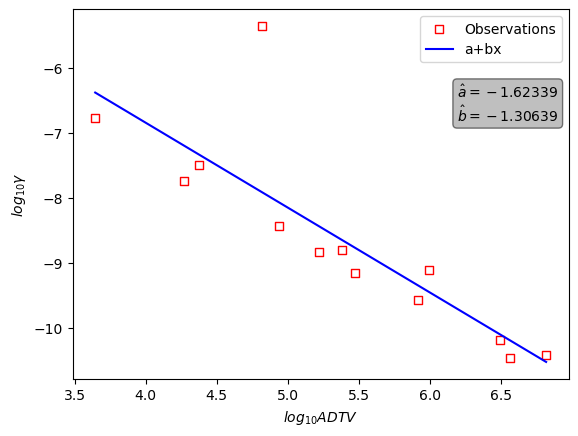

In [72]:
new_df = merged_df.drop(high_leverage_indices)

# fit model
result = ols(formula="log_gamma ~ log_adtv", data=new_df).fit()
a_hat = result.params['Intercept']
b_hat = result.params['log_adtv']

# plot observations
plt.scatter(new_df['log_adtv'], new_df['log_gamma'], label='Observations', marker='s', color='w', edgecolors='r')

# generate ADTV values to predict on
adtv_range = np.linspace(new_df['log_adtv'].min(), new_df['log_adtv'].max(), 100)

# predict gamma
predicted_gamma = a_hat + b_hat * adtv_range

# plot
plt.plot(adtv_range, predicted_gamma, label='a+bx', color='blue')
plt.xlabel('$log_{10}ADTV$')
plt.ylabel('$log_{10}\\gamma$')

plt.legend()

ax = plt.gca()
textstr = f'$\\hat{{a}} = {a_hat:.5f}$\n$\\hat{{b}} = {b_hat:.5f}$'
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)

ax.text(0.775, 0.8, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()